In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join, splitext

In [9]:
from os import listdir


input_dir = '../dataset/test'
output_dir = '../dataset/output'
gt_dir = '../dataset/groundtruth'
numImages = 80

# input_dir = '../add_dataset/test'
# output_dir = '../add_dataset/output'
# gt_dir = '../add_dataset/groundtruth'
# numImages = 20

eps = 0.00000001

onlyfiles = [f for f in listdir(input_dir) if isfile(join(input_dir, f))]
files = onlyfiles[0:numImages]

In [10]:
def showSubplotImage(img, titlestr=""):
    plt.imshow(img, cmap='gray')
    plt.xticks([]), plt.yticks([])
    plt.title(titlestr)
    plt.show()

def setSubplotImage(img, titlestr=""):
    n = len(img)  # Number of images
    
    if n <= 6:
        # If 6 or fewer images, show in a single row
        cols = n
        rows = 1
    else:
        # Otherwise, calculate rows and columns
        cols = int(np.ceil(np.sqrt(n)))
        rows = int(np.ceil(n / cols))

    # Create subplots
    fig, axs = plt.subplots(rows, cols, figsize=(15, 15))
    axs = axs.ravel()  # Flatten axes for easy indexing

    for i in range(n):
        axs[i].imshow(img[i], cmap='gray')
        axs[i].set_title(titlestr[i] if i < len(titlestr) else "")
        axs[i].axis('off')  # Turn off axes

    # Hide any unused subplots
    for i in range(n, len(axs)):
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()


In [11]:
def remove_circle (img) :

        greyScale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        _, binary_mask = cv2.threshold(greyScale, 1, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

        contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        largest_contour = max(contours, key=cv2.contourArea)

        # Create a mask for the circular region
        mask = np.zeros_like(greyScale)
        cv2.drawContours(mask, [largest_contour], -1, 255, -1)

        # Invert the mask to remove the circular boundary
        inverted_mask = cv2.bitwise_not(mask)

        kernel = np.ones((3, 3), np.uint8)
        inverted_mask = cv2.dilate(inverted_mask, kernel,iterations=1)

        return inverted_mask

In [12]:
def segmentImage(img, c_value=5):

    green_channel = cv2.split(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))[1]

    clahe = cv2.createCLAHE(clipLimit=2.5, tileGridSize=(8, 8))
    enhanced_img = clahe.apply(green_channel)

    # Apply median blur to reduce noise
    filtered_img = cv2.GaussianBlur(enhanced_img,(5,5),1) 

    outImg = cv2.adaptiveThreshold(
        filtered_img,
        maxValue=1,
        adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        thresholdType=cv2.THRESH_BINARY_INV,
        blockSize=15,
        C=c_value,
    )        

    # Post-processing to remove small regions
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(outImg, connectivity=8)
    min_size = 45
    for i in range(1, num_labels):
        if stats[i, cv2.CC_STAT_AREA] < min_size:
            outImg[labels == i] = 0

    # Remove the circular region
    remove_circle_img = remove_circle(img)

    outImg = cv2.subtract(outImg, remove_circle_img)

    # END OF YOUR CODE
    #########################################################################
    return outImg

In [13]:
def calculate_result (c_v=5):
    error = np.zeros((numImages,1),)
    precision = np.zeros((numImages,1),)
    recall = np.zeros((numImages,1),)
    iou = np.zeros((numImages,1),)


    for i,name in enumerate(files):
        inputImg = cv2.imread(input_dir + '/' + name)
        outputImg = segmentImage(inputImg,c_v).astype('float32')
        imgName = splitext(name)
        gt = cv2.imread(gt_dir + '/' + imgName[0] + '.png',0)
        gt = np.round(gt.astype('float32')/gt.max())
            
        precision[i] = np.round(sum(sum(gt*outputImg))/(sum(sum(outputImg))+eps),4)
        recall[i] = sum(sum(gt*outputImg))/sum(sum(gt))
        error[i] = 1 - ((2*precision[i]*recall[i])/(precision[i]+recall[i]+eps))
        iou[i] = sum(sum(gt*outputImg))/sum(sum(np.clip(gt+outputImg,0,1)))

    avg_error = np.mean(error,axis=1)
    avg_precision = np.mean(precision,axis=1)
    avg_recall = np.mean(recall,axis=1)
    avg_iou = np.mean(iou,axis=1)

    error = (np.sum(avg_error)/numImages*100)
    precision = (np.sum(avg_precision)/numImages*100)
    recall = (np.sum(avg_recall)/numImages*100)
    iou = (np.sum(avg_iou)/numImages*100)

    # print('Adapted Rand Error: %d%%' % (np.sum(avg_error)/numImages*100))
    # print('Precision: %d%%' % (np.sum(avg_precision)/numImages*100))
    # print('Recall: %d%%' % (np.sum(avg_recall)/numImages*100))
    # print('IoU: %d%%' % (np.sum(avg_iou)/numImages*100))

    return error, precision, recall, iou

#### IMAGE RESULTS ####
+---------+---------+-----------+---------+---------+
| C Value |  Error  | Precision |  Recall |   IoU   |
+---------+---------+-----------+---------+---------+
|    3    | 32.0842 |  58.9365  | 82.8308 | 52.1509 |
|   3.5   | 32.0842 |  58.9365  | 82.8308 | 52.1509 |
|    4    | 28.1818 |  68.6528  | 77.4414 | 56.6023 |
|   4.5   | 28.1818 |  68.6528  | 77.4414 | 56.6023 |
|    5    | 27.4953 |  75.0483  | 72.0161 | 57.3736 |
|   5.5   | 27.4953 |  75.0483  | 72.0161 | 57.3736 |
|         |         |           |         |         |
| Average | 29.2538 |  67.5458  | 77.4294 | 55.3756 |
+---------+---------+-----------+---------+---------+


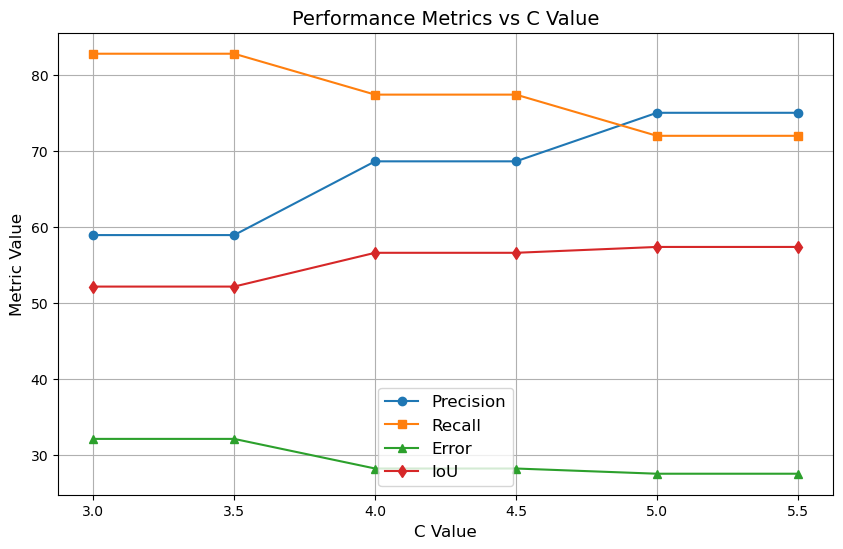

In [14]:
from prettytable import PrettyTable
import numpy as np
import matplotlib.pyplot as plt

# Example Data (Replace with your calculated values)
# test_c = [1, 2, 3, 4, 5, 6, 7, 8, 9]
test_c = [3,3.5,4,4.5,5,5.5]

# Placeholder for results
precisions = []
recalls = []
errors = []
Ious = []

# Calculate and append results
for c in test_c:
    error, precision, recall, Iou = calculate_result(c)
    precisions.append(precision)
    recalls.append(recall)
    errors.append(error)
    Ious.append(Iou)

# Convert to numpy arrays for easier averaging
precisions = np.array(precisions)
recalls = np.array(recalls)
errors = np.array(errors)
Ious = np.array(Ious)

# Calculate average metrics
avg_error = np.mean(errors, axis=0)  # Average error per dataset
avg_precision = np.mean(precisions, axis=0)  # Average precision
avg_recall = np.mean(recalls, axis=0)  # Average recall
avg_iou = np.mean(Ious, axis=0)  # Average IoU

# Create Table
print('#### IMAGE RESULTS ####')
t = PrettyTable(['C Value', 'Error', 'Precision', 'Recall', 'IoU'])

# Add rows for each C value
for i, c in enumerate(test_c):
    t.add_row([
        c,
        str(round(errors[i], 4)),
        str(round(precisions[i], 4)),
        str(round(recalls[i], 4)),
        str(round(Ious[i], 4))
    ])

# Add a separator row and summary statistics
t.add_row([' ', ' ', ' ', ' ', ' '])  # Blank row
t.add_row([
    'Average',
    str(round(np.mean(errors), 4)),
    str(round(np.mean(precisions), 4)),
    str(round(np.mean(recalls), 4)),
    str(round(np.mean(Ious), 4))
])

# Print the table
print(t)

# Plot all metrics on the same figure
plt.figure(figsize=(10, 6))

# Add lines for each metric
plt.plot(test_c, precisions, marker='o', label='Precision')
plt.plot(test_c, recalls, marker='s', label='Recall')
plt.plot(test_c, errors, marker='^', label='Error')
plt.plot(test_c, Ious, marker='d', label='IoU')

# Add labels, title, legend, and grid
plt.xlabel('C Value', fontsize=12)
plt.ylabel('Metric Value', fontsize=12)
plt.title('Performance Metrics vs C Value', fontsize=14)
plt.grid(True)
plt.legend(fontsize=12)

# Show the plot
plt.show()
